<a href="https://colab.research.google.com/github/purpal9/RF_FRP_v1/blob/main/NOAA_workshop_2024_ML_for_FRP_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Machine Learning for Fire Radiative Power Modeling
**Christina Kumler**
Cooperative Institute for Research in Environmental Sciences at the University of Colorado Boulder (CIRES) and Global Systems Laboratory (GSL)

Built Fall 2023 - Spring 2024

**[Short-Range Prediction of Wildfire Intensity with Random Forest Model using Weather Forecast and Satellite Fire Radiative Power Observations](https://github.com/purpal9/RF_FRP_v1/blob/28f81418cfd4e7823ababd43c8848c2352b12adb/Kumler_FRP_ML_manuscript.pdf)**

Welcome to the machine learning (ML) for Fire Radiative Power (FRP) notebook! In this two-part notebook, we will explore how to train a ML model called a Random Forest (RF) to model FRP one hour into the future. This notebook has several sections and two main parts. In the Environment Part 0, we will import all the necessary environments to run through the notebook.

## Overview
This interactive notebook is designed for beginner level machine learning and data processing. In Part 1, we will go through a small example to learn how to obtain the input files used to create a machine learning ready (ML-ready) dataset, and how to process the data into a dataset. This is the section that shows the process for developing the dataset, but to keep the notebook simple, this is not the dataset that will be used in part 2 when we learn how to train and test a RF model.

In Part 2, we begin by importing a pre-processed, ML-ready dataset. Then, we will go through the steps on how to train and test a RF model to predict hourly FRP. After, we will demonstrate some package options for analyzing your RF model's performance.

If you are interested in using a pre-processed dataset to train RF models, please run through section 0 and then skip forward to section 2.

### Learning Outcomes
By the end of this tutorial, you will have:
* learned how to pull RAP data using Herbie
* import RAVE data
* process data into an ML-ready dataset.

Additionally, you will have learned how to:
* use that ML-ready dataset in practice to train a RF model
* visualize the performance of that model.

### Prerequisites
This is considered a beginner to intermediate notebook for python-based machine learning. It is helpful to have basic functioning knowledge of the python programming language. This includes using dataframes. To learn more about any of the tools or more specifics on the machine learning methods in this notebook, please visit the provided references.

## Background
FRP detection of wildland fires is important in calculating a variety of variables, such as smoke emissions, which are necessary for fire weather and air quality simulations. FRP is derived from satellite observations of radiative energy emitted by fires. Modeling FRP into the future has impacts on fire behavior as well as aerosols and smoke modeling. There are challenges to modeling this in real-time, including both missed and false detections as well as errors in retrievals. Satellite scanning angles and resolutions, smoke plumes, and clouds can cause additional challenges. To use satellite data in modeling applications, typically averages over previous FRP instead of continuous FRP are used as inputs. To help provide more continuous FRP forecasts, modeling methods can be applied to previously observed satellite FRP. For this notebook, we look to model hourly FRP from previously observed satellite data combined with numerical weather model inputs.


Enjoy!

# 0.1 Setting up a python environment

**In this section, we will import some necessary tools to set up an environment that can download relevant input data, perform data analysis and processing steps, and train RF ML models. Because we are working in a colab notebook, the environment and resources stay connected to this environment and will not impact your local machine. To the left of the notebook, you will find the toolbar that shows the layout of the notebook, a list of current variables, and any additional files contained in the notebook. Note, you should always practice caution when installing packages or tools onto a local machine, as version mismatches can sometimes impact previously developed code. Always practice good code and environment management.**

The following will install wget, a useful tool for "getting" data stored on an internet server by pointing to its location and downloading it to this notebook. This is done directly from python with the following code. In this notebook, we will install each package step by step, however in this first example for `wget`, a loop is provided so that this can be used in other applications with one or multiple packages.

In [ ]:
# sys provides access to system level information (i.e., the executable for the Python installation)
import sys
# subprocess makes system level calls
import subprocess

# PACKAGES is a list of non-standard library, scientific packages to install.
# Note that packages should be pip installable
PACKAGES = ["wget"]

# Loop through each package to either import or install
for package in PACKAGES:
    try:
        # First, attempt to import the package
        __import__(package)
    except ImportError:
        # If package import is unsuccessful, install using pip
        # The command structure is <python executable> -m pip install <package>
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

import wget

Next, we check that things installed correctly

In [ ]:
import sys
print(sys.executable)

Once we have confirmed that things installed correctly, we will install a tool developed for pulling a variety of weather model outputs called: HERBIE. The source code, documentation, and tutorials can be found here: [HERBIE](https://herbie.readthedocs.io/en/stable/user_guide/index.html). In section 1.1.2 we will practice using HERBIE to extract RAP files and store variables into datasets and xarrays. This is the documentation that will be referenced and can also be found in the references section at the end of the notebook.


In [ ]:
HERBIE_pack = 'git+https://github.com/blaylockbk/Carpenter_Workshop.git'
subprocess.check_call([sys.executable, '-m', 'pip', 'install', HERBIE_pack])

subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ecmwflibs'])


In [ ]:
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'herbie-data'])

We will install one last python tool in this section for reading data that is collected in a specific format called NetCDF.

In [ ]:
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'netCDF4'])

In [ ]:
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xarray[complete]'])


In [ ]:
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'cfgrib'])


# 1.1 Importing desired data

**In this section, we set up the code that gets the desired variable inputs. It is important to note that should you desire to train your own machine learning model, and later use this model in your own applications, which is referred to as _inference_ , then you will need to pull as much data as possible and keep the data inputs consistent.**

**We will be extracting two types of data here. The first is the input data from the RAP weather model. These files are very large, so this code is designed to extract specific variables from the full RAP files. If you desire additional variables, please reference RAP's material to identify the variable names. The second data were are inputting is label for our ML model, which is the RAVE fire radiative power (FRP) data.**


1.1.1 Here we pull the RAVE data [Fangjun Li et al.] as our satellite FRP data source. While  RAVE is fully operational, there is no online portal for making data requests or pulls. In this tutorial, we will collect a sample daily RAVE data file, from Zenodo, by using a wget command.

In [ ]:
RAVE_nc = wget.download('https://zenodo.org/records/10694507/files/RAVE-HrlyEmiss-3km_v2r0_blend_s202209010000000_e202209012359590_c202308071356470.nc?download=1')

In this notebook, we will be making a an example dataset that includes 2 hours of data. Since RAVE is stored in a daily netcdf file, we only need to read one file into the colab space. We will save this file into python using an extension called netCDF4. To learn more about the netcdf file structure, please visit: https://www.unidata.ucar.edu/software/netcdf/

In [ ]:
import netCDF4 as nc

rave_data = nc.Dataset(RAVE_nc)
print ('opened RAVE file')

Congratulations! We have successfully pulled a daily RAVE data file and stored it into our notebook space as "rave_data" which can be referenced later as we process our own miniature RF-ready dataset. If you'd like to see where the RAVE file went, you can look at the left of the colab notebook and click the **folder icon** and see that the file now is saved into the colab notebook space.

1.1.2 Next, we use HERBIE in the processing script to access the RAP data. Note that documentation specific to HERBIE can be found in the previous section 0.1 as well as in the reference section at the end of the notebook. RAP data is fairly messy, with having different naming conventions and products, etc. HERBIE is a very useful tool at helping navigate some of these nuances. When building your own training dataset, be sure to know what input data you are using, if they change with model updates, if their naming changes, if they are not available on the time scale you need them, etc.

There are two ways to use HERBIE. First, we could use HERBIE to save the raw RAP file into a working or subdirectory. However, this tutorial will use HERBIE to access the RAP data in a HERBIA object, which means we will never actually have to save and reopen the RAP data. We could download the whole RAP file to the notebook using a different method, referenced in section 1.1.3.

Below is an example of how this will look later in the notebook. We are going to grab a single file for our date of interest: September 1, 2022.



In [ ]:
from herbie import Herbie
from toolbox import EasyMap, pc
from paint.standard2 import cm_tmp
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

Below is the code where HERBIE grabs a desired RAP file, based on initialization time and forecast hour. Certain variables are available in certain products, so please reference HERBIE's page on directions that explain the different models and products. We are interested in temperature, wind gust, and vegetation type. These are contained in two different products, so we read in both products into two HERBIE objects. In this example, we are using HERBIE to grab the RAP model output from Jan 1 2024 at 6UTC at the 0 forecast hour.

For each model product, which is explained in the next text block, we save a HERBIE object, both H and G in this instance. From that object, we read the desired variables into xarray datasets.

In [ ]:
#Create a Herbie object for specified date, model, and forecast
H = Herbie("2024-01-01 06:00", model="rap", fxx=0)
# store desired variables into a list containing multiple datasets
ds = H.xarray("(?:TMP:2 m|GRD:10 m|DPT:2 m|GUST|RH: 2 m)")
# OR store desired variables into multiple datasets by like variables
ds1 = H.xarray(":(?:TMP|RH):2 m")
ds2 = H.xarray("GUST")
ds3 = H.xarray("DPT:2 m")
print("HERBIE object H: ", H)

G = Herbie("2024-01-01 06:00", model="rap", fxx=0, product="awp130bgrb")
dg = G.xarray("(?:SOIL|TOSIL)")
print("HERBIE object G: ", G)


Above, we read in two RAP files, H and G, separately. This is because different variables are stored in different RAP files. The following will show all product options for RAP. Not all products contain the desired variables. We can see the "awp130bgrb" product listed here. To learn more about model products and how to list variables contained in each, please reference the HERBIE documentation.

For this tutorial, we are interested in some near-ground level weather variables, stored in HERBIE object H, as well as soil information, which is contained in a separate RAP product and for which we have created a second G object.

In [ ]:
H.PRODUCTS

You might have noticed the two different ways in which we saved desired variables into datasets. Either a lumped dataset object list, ds, or separate like-variables into their own datasets. Below we will look at the difference in output between these methods. For the multiple datasets method, note the names of the data variables, since this will be used in our data processing section.

In [ ]:
## List the contents of the xarrays
## note the variables we will reference are defined in 'Data Variables'
print("ds1: ", ds1)

In [ ]:
## List the contents of the xarrays
## note the variables we will reference are defined in 'Data Variables'
print("ds2: ", ds2)

In [ ]:
## List the contents of the xarrays
## note the variables we will reference are defined in 'Data Variables'
print("ds3: ", ds3)

In [ ]:
## List the contents of the xarrays
## note the variables we will reference are defined in 'Data Variables'
print("dg: ", dg)

If we print the contents of the ds list that we created, we notice that the output is different. For more information on reading model data output and selecting model variables, reference the HERBIE documentation and tutorials.

In [ ]:
## List the contents of the xarrays read in one lump
print("ds: ", ds)

Below is a demonstration on how we will use HERBIE in the processing code to extract specific variables from the RAP data from the previously created datasets. In this example, we are extracting data from RAP's 2m temperature, as well as the latitude and longitude values, on September 1 2022 at 0UTC.

In [ ]:
# these are all numpy vectors
lat = ds1.latitude.values
lon = ds1.longitude.values
tmp_2m = ds1.t2m.values
rh_2m = ds1.r2.values
gust = ds2.gust.values
d2m = ds3.d2m.values
print('Print a single temp from index [260,34]: ', tmp_2m[260, 34])

In [ ]:
## Store additional varibles into numpy vectors
soilw = dg.soilw.values
soilt = dg.st.values

Congratulations, we have successfully grabbed input variables from a RAP file using the HERBIE tool. This is the same method that will be used in the next section of this notebook.

1.1.3 We will use similar commands and tools in section 1.2 when we process the dataset. But reminder that HERBIE is a tool. If you prefer to substitute this method with pynio in your own practice outside of this colab notebook, that would work the same way. Below is code how to open a RAP grib2 file called *RAP_FILE* and store it into a dataset grbs:


```
grbs = xr.open_dataset(RAP_FILE,
         engine='pynio',
         lock=False,
         backend_kwargs=dict(format="grib2"),
         )
```

If you have exatracted the whole RAP file, or even a subset, then you will be able to reference variables by the names provided in RAP documentation: https://www.nco.ncep.noaa.gov/pmb/docs/grib2/grib2_doc/grib2_table4-2.shtml. When you know which variables are of interest, then this is code on how to select specific varialbes and their values to store into a xarray.

```
temp2m_var = grbs['TMP_P0_L103_GRLL0'].values
```

would store temperature at 2m into a variable named *temp2m_var*

# 1.2 Processing the Data

**In this section, we will process the RAVE data that we imported with RAP variables to create an ML ready dataset. There are different ways we could coose to build an ML-ready dataset based on what type of ML model we would like to train. For modeling hourly FRP, we are interested in each grid cell where there is a non-zero FRP point from the time step before. We could either design an ML-ready dataset on the whole domain or we can store data in a tabular method where each hour there are entries where there are non-zero FRP points. To train the RF ML model, we can choose to store the ML-ready dataset in a tabular method. This means that we will process the inputs for each non-zero FRP point in the RAVE dataset, by each hour, and pair it with the corresponding RAP gridcell weather variable data and the latitude/longitude location and hour of day. As we do this, we will then store the combined data into a tabular CSV format. For this notebook, we made this choice because we seek to model hourly FRP once a fire is burning. We are not interested in zero values for FRP and therefore not interested in RAP gridcells that have zero values for FRP.**


1.2.0 First, we will load the python tools needed to perform the data merge

In [ ]:
import xarray as xr
import netCDF4 as nc
import datetime
import pandas as pd
import numpy as np
import datetime
import netCDF4 as nc
from pyproj import Proj
import os
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
import gc
import numpy.ma as ma
import pygrib
import glob
import matplotlib.pyplot as plt

Then we create a colab folder to store, or output, the processed hourly CSV files in once they have been created.

In [ ]:
# Check to see if the subdirectory exists already
# If it does not, make a new subdirectory
if not os.path.exists("RAVE_RAP_proc"):
    os.makedirs("RAVE_RAP_proc")

1.2.1 In the following subsection, we will write program blocks that will be used in a main coding block in section 1.2.2 that will merge RAP and RAVE data by hour and location to make hourly files that contain an FRP, location, time of day, and weather variables. But first, we start with defining the location of the output csv files and the columns, which is the future list of inputs, of the dataframes that we will store into the csv files. We have restated the file names, mostly for the benefit of this notebook and keeping track of which files we are using. If more files are wished to be used in an iterative process, this block of code could be modified with directory locations instead of specific file names or variables.

In [ ]:
# Where to store the files?
out_directory = './RAVE_RAP_proc'
# What was the input RAVE file?

In [ ]:
# define columns to be output with files
columns = ['dateTime', 'id', 'lat', 'lon', 'FRP',
        'temp2m', 'rh_2m', 'd2m',
        'gust', 'soilw', 'soilt']

Next, we define some *functions* that are used by the main code to process the files together. Functions are useful in python because they can be used at any part of the code and called by different scripts and codes.

The first function is called:

```
non_zero()
```

This function will locate all non-zero FRP points and store them into a python object called a tuple.



In [ ]:
def non_zero(rave_frp):
    # locates all indicies for RAVE nc file that have non-zero FRP
    # stores these in a tuple nzi
    frp_0 = rave_frp[:,:]
    ff = frp_0 > 0
    ff.astype(np.int_)
    # Non-zero FRP index values from files
    nzi = np.nonzero(ff)

    return nzi

The next function is called

```
mergedata
```

as is the will confirm we have two input files ready to be used. It then calls a function called

```
create_proc
```

that returns a completed dataframe object. The dataframe object, called

```
df
```

will be the merged RAVE-RAP dataset for a specified hour. At the end of this function, we save and export the dataframe into a csv file. Note that create_proc takes two different RAP HERBIE files because our desired processing code wants variables in different products. If you wish to add more or less, you might need to modify create_proc to take additional or fewer rap_file names.


In [ ]:
def mergedata(date, h, RAVE_file, outfile):
    # open RAVE file
    rave_data = nc.Dataset(RAVE_file)
    # Confirm that the file we are looking for exists
    print ('opened RAVE file')

    #open RAP files via HERBIE
    rap_file_1 = Herbie(date, model="rap" , fxx=0)
    rap_file_2 = Herbie(date, model="rap" , fxx=0, product="awp130bgrb")
    # Confirm that the file we are looking for exists
    print("I found the RAP data: ", rap_file_1 , " and : ", rap_file_2)

    # call the processing program and save dataframe to csv
    df = create_proc(date, h, rap_file_1, rap_file_2, rave_data)
    df.to_csv(outfile, index=False)

    # Delete old dataframe
    del df
    gc.collect()

Below is the last function that we will define, called

```
create_proc
```

and will do the bulk of the data processing. Here, we read through the RAVE file and for each FRP point, we go into the RAP file and pull the closest latitude and longitude point as well as the variables of interest. We only do a small subset here, but this is where code could be modified to pull any variables contained in the RAP files.

The function states with creating an empty dataframe object to populate with all the curren hour's FRP values and RAP variables.

The function then reads in all RAVE data, removes the mask that the data are provided with, and collects the non-zero FRP values. It stores these FRP values and the corresponding latitude and longeitude values into a little dataframe that is looped through by index.

Next, the function enters the loop that cycles through the non-zero FRP values. First in this loop, a few lines of code are didctated to finding the nearest latitude and longitude RAP grid-cell points to the corresponding FRP latitude and longitude. Once those are found, their indicies are saved into a variable called

```
rap_close
```

that will be used to extract the closest RAP grid variable(s) to the RAVE FRP observation. This is done in an "if" loop because we are appending this information into the larger dataframe objeect. This is just one way in which to pair the data.

In [ ]:
def create_proc(date, h, rap_file_1, rap_file_2, rave_data):
    df = pd.DataFrame(columns=columns)

    rave_frp = rave_data.variables['FRP_MEAN'][h,:,:] #masked size (1, 1133, 2500) MW
    rave_latt = rave_data.variables['grid_latt'][:] #size (1133, 2500) #center grid that is 3km
    rave_lont = rave_data.variables['grid_lont'][:] #size (1133, 2500) #center grid that is 3km

    # remove the mask, which fills the null values with -1, and keeps values
    rave_frp = rave_frp.filled()

    # find the non-zero FRP indicies in RAVE
    nzi = non_zero(rave_frp)

    # storing all non-zero FRP points from other variables
    frp_rave = rave_frp[(nzi[0]),(nzi[1])] # will be the length of the number of non-zero FRP points
    frplatt_rave = rave_latt[(nzi[0]),(nzi[1])] # will be the length of the number of non-zero FRP points
    frplont_rave = rave_lont[(nzi[0]),(nzi[1])] # will be the length of the number of non-zero FRP points

    # set up dataframe of the non-zero RAVE variables for current hour and RAP variables
    rave_df = pd.DataFrame(columns = ['grid_lont', 'grid_latt', 'FRP'])

    # storing all those variables into the beginning of a dataframe
    rave_df['FRP'] = frp_rave
    rave_df['grid_latt'] = frplatt_rave
    rave_df['grid_lont'] = frplont_rave

    print('made rave dataframe rave_df')

    first = int(0)

    # Make a dataset from desired variables in HERBIE
    H = rap_file_1
    ds1 = H.xarray(":(?:TMP|RH):2 m")
    ds2 = H.xarray("GUST")
    ds3 = H.xarray("DPT:2 m")

    G = rap_file_2
    dg = G.xarray("(?:SOIL|TOSIL)")

    # loop through the RAVE FRP dataframe
    for ind in rave_df.index:

        lat_test = ds1.latitude.values.flatten()
        lon_test = ds1.longitude.values.flatten()
        rap_map = pd.DataFrame({"raplat": lat_test, "raplon": lon_test})

        frp_lat = rave_df['grid_latt']
        frp_lon = rave_df['grid_lont']
        frp_pt = pd.DataFrame({"Lat": frp_lat, "Lon": frp_lon})
        single = np.array((frp_pt.at[ind,'Lat'], frp_pt.at[ind,'Lon']))
        single = single.reshape(1,2)

        # single is [lat lont]
#        print('single: ', single)

        # find the nearest RAP grid indicies to match RAVE data lat and lon
        ln_test = lon_test-360
        lt_test = lat_test-360
        frp_lt = frp_pt.at[ind,'Lat']-360
        frp_ln = frp_pt.at[ind,'Lon']-360
        abslon = np.abs(ln_test - frp_ln)
        abslat = np.abs(lt_test - frp_lt)
        c = np.maximum(abslon, abslat)

        idx = np.argmin(c)
#        print('idx: ', idx)
        rap_close = idx
#        print('rap_close: ', rap_close)

        if np.isnan(frp_lat[ind]):
            rap_close = float("NAN")
        # For the first time, we build a df. All other times, we will append
        if first == 0:
            first = int(1)
            # check for NaN and fill with NaN
            if np.isnan(rap_close):
                data_df = pd.DataFrame({"lat": float("NAN"),
                                        "lon": float("NAN"),
                                        "temp2m": float("NAN"),
                                        "rh_2m": float("NAN"),
                                        "d2m": float("NAN"),
                                        "gust": float("NAN"),
                                        "soilw": float("NAN"),
                                        "soilt": float("NAN"),
                                        "FRP": float("NAN"),
                                        "id": float("NAN"),
                                        "dateTime": float("NAN")}, index=[0])
            else:
                # Store the closest-matched RAP grid cell variable with the RAVE FRP
                data_df = pd.DataFrame({"lat": ds1.latitude.values.flatten()[rap_close],
                                        "lon": ds1.longitude.values.flatten()[rap_close],
                                        "temp2m": ds1.t2m.values.flatten()[rap_close],
                                        "rh_2m": ds1.r2.values.flatten()[rap_close],
                                        "d2m": ds3.d2m.values.flatten()[rap_close],
                                        "gust": ds2.gust.values.flatten()[rap_close],
                                        "soilw": dg.soilw.values.flatten()[rap_close],
                                        "soilt": dg.st.values.flatten()[rap_close],
                                        "FRP": rave_df['FRP'][ind],
                                        "id": rap_close,
                                        "dateTime": [date]}, index=[0])
            df = pd.DataFrame(data=data_df, index=[0])
            del data_df
        else:
        # Append FRP and RAP together in a dataframe
            if np.isnan(rap_close):
                data_df2 = pd.DataFrame({"lat": float("NAN"),
                                        "lon": float("NAN"),
                                        "temp2m": float("NAN"),
                                        "rh_2m": float("NAN"),
                                        "d2m": float("NAN"),
                                        "gust": float("NAN"),
                                        "soilw": float("NAN"),
                                        "soilt": float("NAN"),
                                        "FRP": float("NAN"),
                                        "id": float("NAN"),
                                        "dateTime": float("NAN")}, index=[0])
            else:
                data_df2 = pd.DataFrame({"lat": ds1.latitude.values.flatten()[rap_close],
                                        "lon": ds1.longitude.values.flatten()[rap_close],
                                        "temp2m": ds1.t2m.values.flatten()[rap_close],
                                        "rh_2m": ds1.r2.values.flatten()[rap_close],
                                        "d2m": ds3.d2m.values.flatten()[rap_close],
                                        "gust": ds2.gust.values.flatten()[rap_close],
                                        "soilw": dg.soilw.values.flatten()[rap_close],
                                        "soilt": dg.st.values.flatten()[rap_close],
                                        "FRP": rave_df['FRP'][ind],
                                        "id": rap_close,
                                        "dateTime": [date]}, index=[0])
            hold_df_2 = pd.DataFrame(data=data_df2, index=[0])
#            df = df.append(hold_df_2, ignore_index=True)
            df = pd.concat([df, hold_df_2], ignore_index=True)

            del hold_df_2
        # else it was a missing RAP and should be NAN
    else:
        data_df = pd.DataFrame({"lat": float("NAN"),
                                        "lon": float("NAN"),
                                        "temp2m": float("NAN"),
                                        "rh_2m": float("NAN"),
                                        "d2m": float("NAN"),
                                        "gust": float("NAN"),
                                        "soilw": float("NAN"),
                                        "soilt": float("NAN"),
                                        "FRP": float("NAN"),
                                        "id": float("NAN"),
                                        "dateTime": float("NAN")}, index=[0])
    return df

1.2.2 Lastly, this is our main function. The main function allows us to loop through multiple files at multiple time steps to create RAVE-RAP hourly files. We will process two hours of files to create the ML and RF ready dataset.

In the following code, we define our main function. In that main function, we loop through time. We check and grab our desired input data files. We then run a function, called

```
mergedata()
```

This function is where we call that large, longest function called

```
create_proc()
```

That is the function that we defined earlier in the notebook that does our heavy lifting. This function takes the date, RAP file, RAVE file, and output file name as inputs. With these inputs, it will check and read both the selected RAVE and RAP files for the same hour. It will then match the RAVE data location with RAP gridcell, select the RAP variables of interest for the location, create a dataframe object listed by the non-zero FRP points, and finally export/save the dataframe into a csv format.


In [ ]:
# define a main function %
# We are only processing two hours of files from 9-1-22
year = 2021
def main():
    for m in range(9, 10):       # specify your month range
        for d in range(1, 2):   # specify your day range
            for h in range(1,3): # the files are daily for RAVE but we want hourly files produced
                try:
                    date = datetime(year, m, d, h)
                    print('Working on date: ', date)
                    # recall that we have already saved the RAVE file in a 1.1.1 as "RAVE_nc"
                    RAVE_file = RAVE_nc
                    print ('pulled RAVE file', RAVE_file)
                    # Make the name and location of the output processed file we will save
                    outfile = os.path.join(out_directory, "%s.csv" % (date.strftime("%y%m%d%H")))

                    # Run the merging functions
                    mergedata(date, h, RAVE_file, outfile)

                    # confirm the output file
                    print ("Wrote to %s" % outfile)

                except ValueError as e:
                    pass
                    print("date for file doesn't exist")

if __name__ == '__main__':
    main()

Congratulations! You have now exported hourly csv files, containing the hourly dataframe tables of FRP and RAP data, which can be used to train a machine learning model such as the random forest.

From these files, a number of computations can be made and/or applications could be done. For instance, one computation can be if we are interested in calculating a rolling 24-hour average FRP value, then we can write code to read each hour for 24 hours, sum the non-zero FRP for a same latitude and longitude grid value, and then finally the mean over that grid. In fact, that is a value found in section 2 as an input into a demo RF model.


1.2.3 If you desire to merge these csv files into a larger, singular dataset csv file. The code can be found below.

In [ ]:
path = './RAVE_RAP_proc'
extension = '.csv'

files = [file for file in os.listdir(path) if file.endswith(extension)]

dfs = []
for file in files:
    df = pd.read_csv(os.path.join(path, file))
    dfs.append(df)
#    dfs.concat(df)

frp_all = pd.concat(dfs, ignore_index=True)

frp_all.to_csv('./RAVE_RAP_dataset.csv', index = False)

# 2.1 Training a Random Forest for FRP from the RAVE-RAP Dataset Example

**In this section, we import a large RAVE-RAP dataset created from data in July 2018 through December 2021. We will then train RF models from this dataset and visualize their performance on blind validation datasets and datasets that meet certain specified credentials.**

**MUST DO BEFORE PROCEEDING**: You are going to need to change the colab compute resources to complete the model training in this colab workspace in a timely manner. To do this:

> 1) Look to the upper right, possibly below comment and share if you have not hidden the colab header, where it shows the RAM and Disk icons. **Click the RAM and Disk icons**, not the dropdown arrow, to reveal the Resources tab.

> 2) At the bottom of that tab is an option that says Change runtime type. Click **Change runtime type** and select **T4GPU** and then select okay, and then finally press save.

You can then close the Resources tab by clicking the X next to Resources.

To do this, we first need to gather the AI ready dataset from Zenodo: https://zenodo.org/records/10463552 . Note that this step might take several minutes in total. The first wget request will get the dataset, which we will call:

```
frp_all
```

Before we make the wget request, we will start from scratch and clear out everything we did in our working space from sections 0 and 1. This includes removing from the working space all previous variables and ensuring that all python tools have been re-imported. You will want to type "y" once prompted.

In [ ]:
%reset

!pip install wget

import sys
import wget
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree


import matplotlib.pyplot as plt
import matplotlib.lines as mlines

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=284cab90f99ac5c64aafb4b0f4071b87c127d9bf95b13ffbc00578781a8ceb3b
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


2.1.1 Next, we will get and download the RF-ready dataset and save it as a dataframe object.

In [ ]:
frp_csv = wget.download('https://zenodo.org/records/10790965/files/RAVE_RAP_2019_2021.csv?download=1')
frp_all = pd.read_csv(frp_csv)

You can click the folder icon on the far left to see that the csv file has been got from the Zenodo database and saved to the colab space. You can also note how large the file is.

Lastly, we will check for any NaN values and drop those rows from the dataset.

In [ ]:
## drop the rows with NaNs
frp_all.dropna(axis=0, subset=['rave_frp', 'time','lat', 'lon', 'hour', 'temp2m', 'wind_gust', 'precip', 'dpt', 'uwind', 'vwind',
                                'temp_surf', 'snod', 'spfh', 'pwat', 'weasd', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
                                'cape', 'ltng', 'tsoil', 'soilw', 'vgtyp', 'sotyp',
                                'yester_frp', '24hr_roll_frp'], inplace=True)

2.1.2. In this section, here is where we can modify the dataset for whatever training conditions we wish to apply. This is where understanding your input data becomes important. In our example, the RAVE dataset includes all observed hourly FRP detections, and while it is a well created dataset, it can include false observations and detections as well as encounter other errors and biases associated with satellite retrieved FRP values. One such example might be satellite signatures such as bright flares, etc. can register as weaker FRP values.

In this training this ML model, we are attempting to model hourly FRP with known previous FRP information as well as current weather information from RAP. As is similarly seen in other operations, a good way to ensure a comprehensive understanding of previous FRP on a gridded domain is to take a mean of previously observed FRP over some period of time. This helps avoid missed hourly intervals due to cloud or smoke blocking, satellite orbit, etc. There are two mean values included in this dataset:
> **yester_frp** which is a mean FRP value that was calculated from 0-23 UTC of the day-before hourly observed FRPs from the corresponding gridcell of the current hour FRP.

> **24hr_roll_frp** which is a mean FRP value that was was calculated as a mean up to the hour before the listed FRP value and observation.

These pre-calculated values can help refine our ML model training process to make sure that is could perform in real time, since it isn't dependent on a singular previous hour FRP, and help compensate for some of the satellite and/or missing value issues.

[reference my publicaiton here?]


In [ ]:
## Create a dataset for training data with conditionals

## REQUIRED: drop rows where 24hr_roll_frp = 0
frp_all = frp_all.loc[~((frp_all['24hr_roll_frp'] <= 0))]
frp_all['24hr_roll_frp'] = frp_all['24hr_roll_frp'].fillna(0)

The following code block is optional code and all commented out. We can specify any additional conditionals to apply to our dataset, if we have interest in training a model that specifically looks at certain regions or has certain conditions. This can include location, input variable thresholds, etc. In this case, there is an example of how to specify a certain region. To add conditionals, either uncomment the single "#" existing code below, or inset your own. Then execute the block.


In [ ]:
## -- Here are examples where we can specify the region -- ##
## drop the lons east of 105

#indexNames = frp_all[frp_all['lon'] >= -105 ].index
#frp_all.drop(indexNames , inplace=True)
#size_frp_all_3 = frp_all.shape
#print('size of western lons: ', size_frp_all_3)
## drop the lats south of 25
#indexNames = frp_all[frp_all['lat'] <= 25 ].index
#frp_all.drop(indexNames , inplace=True)
#size_frp_all_3 = frp_all.shape
#print('size of northern lats: ', size_frp_all_3)

## -- Here are examples where we can specify other conditionals, like
## -- selecting points only where a fire was burning the time before -- ##
## drop rows where 24hr_roll_frp = 0
#frp_all = frp_all.loc[~((frp_all['24hr_roll_frp'] <= 0))]
#frp_all['24hr_roll_frp'] = frp_all['24hr_roll_frp'].fillna(0)

Lastly, we will extract some specific dates to remove from our machine learning training and testing process. These dates can later be referenced for the final blind-validation of the model performance.

In [ ]:
# Specify the desired time(s) to withold for validation
t1 = frp_all[(frp_all['time'] <= '2019-11-01') & (frp_all['time'] > '2019-08-01')]
t2 = frp_all[(frp_all['time'] <= '2020-09-25') & (frp_all['time'] > '2020-08-25')]
frp_validate = pd.concat([t1, t2])

# Remove those same times from the main dataset
frp_all=frp_all[~(frp_all['time'] <= '2019-11-01') & (frp_all['time'] > '2019-08-01')]
frp_all=frp_all[~(frp_all['time'] <= '2020-09-25') & (frp_all['time'] > '2020-08-25')]

In [ ]:
## check the number of total samples for testing and training
n_samples = frp_all.shape[0]

2.1.3 Here is where we will train the RF model to predict the next-hour FRP. This time, we are using the pre-loaded machine-learning ready dataset that we just created. To reference Regressor options in depth, please visit: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

This code takes around 15-20 minutes to run as written. If you changed the estimators and random state, it might take your model less or more time to train.

In [ ]:
## Create the list of features we will have as inputs
feature_list = list(['lat', 'lon', 'hour', 'temp2m', 'wind_gust', 'precip', 'dpt', 'uwind', 'vwind',
                                'temp_surf', 'snod', 'spfh', 'pwat', 'weasd', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
                                'cape', 'ltng', 'tsoil', 'soilw', 'vgtyp', 'sotyp', '24hr_roll_frp'])

## Create the features dataframe we will use as inputs
features = frp_all[['lat', 'lon', 'hour', 'temp2m', 'wind_gust', 'precip', 'dpt', 'uwind', 'vwind',
                                'temp_surf', 'snod', 'spfh', 'pwat', 'weasd', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
                                'cape', 'ltng', 'tsoil', 'soilw', 'vgtyp', 'sotyp', '24hr_roll_frp']]

## Labels
labels=frp_all['rave_frp']


## Split dataset into training set and test set
indices = np.arange(n_samples)
train_features, test_features, train_labels, test_labels, idx1, idx2 = train_test_split(features, labels, indices, test_size=0.3) # 70% training and 30% test

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

## RF model where we can specify any number of parameters.
## n_estimators = number of trees in the forest
## random_state = integer chosen to insure reproducable results
## maximum depth of the tree is 5
rf_model = RandomForestRegressor(n_estimators = 20, random_state = 10, max_depth = 5)

## Train the model on training data
rf_model.fit(train_features, train_labels);

## Use the forest's predict method on the test data
predictions = rf_model.predict(test_features)
all_frp = rf_model.predict(features)

Training Features Shape: (292532, 25)
Training Labels Shape: (292532,)
Testing Features Shape: (125372, 25)
Testing Labels Shape: (125372,)



Congratulations, you have trained your first random forest model to take a set of inputs from current hour weather conditions and previous hours' FRP information, and model the current hour FRP.


If you want to visualize an individual tree, the code below will display the trees of which ever specified estimator. Just remember that you must specify an estimator in the range of the model's defined number of estimators.

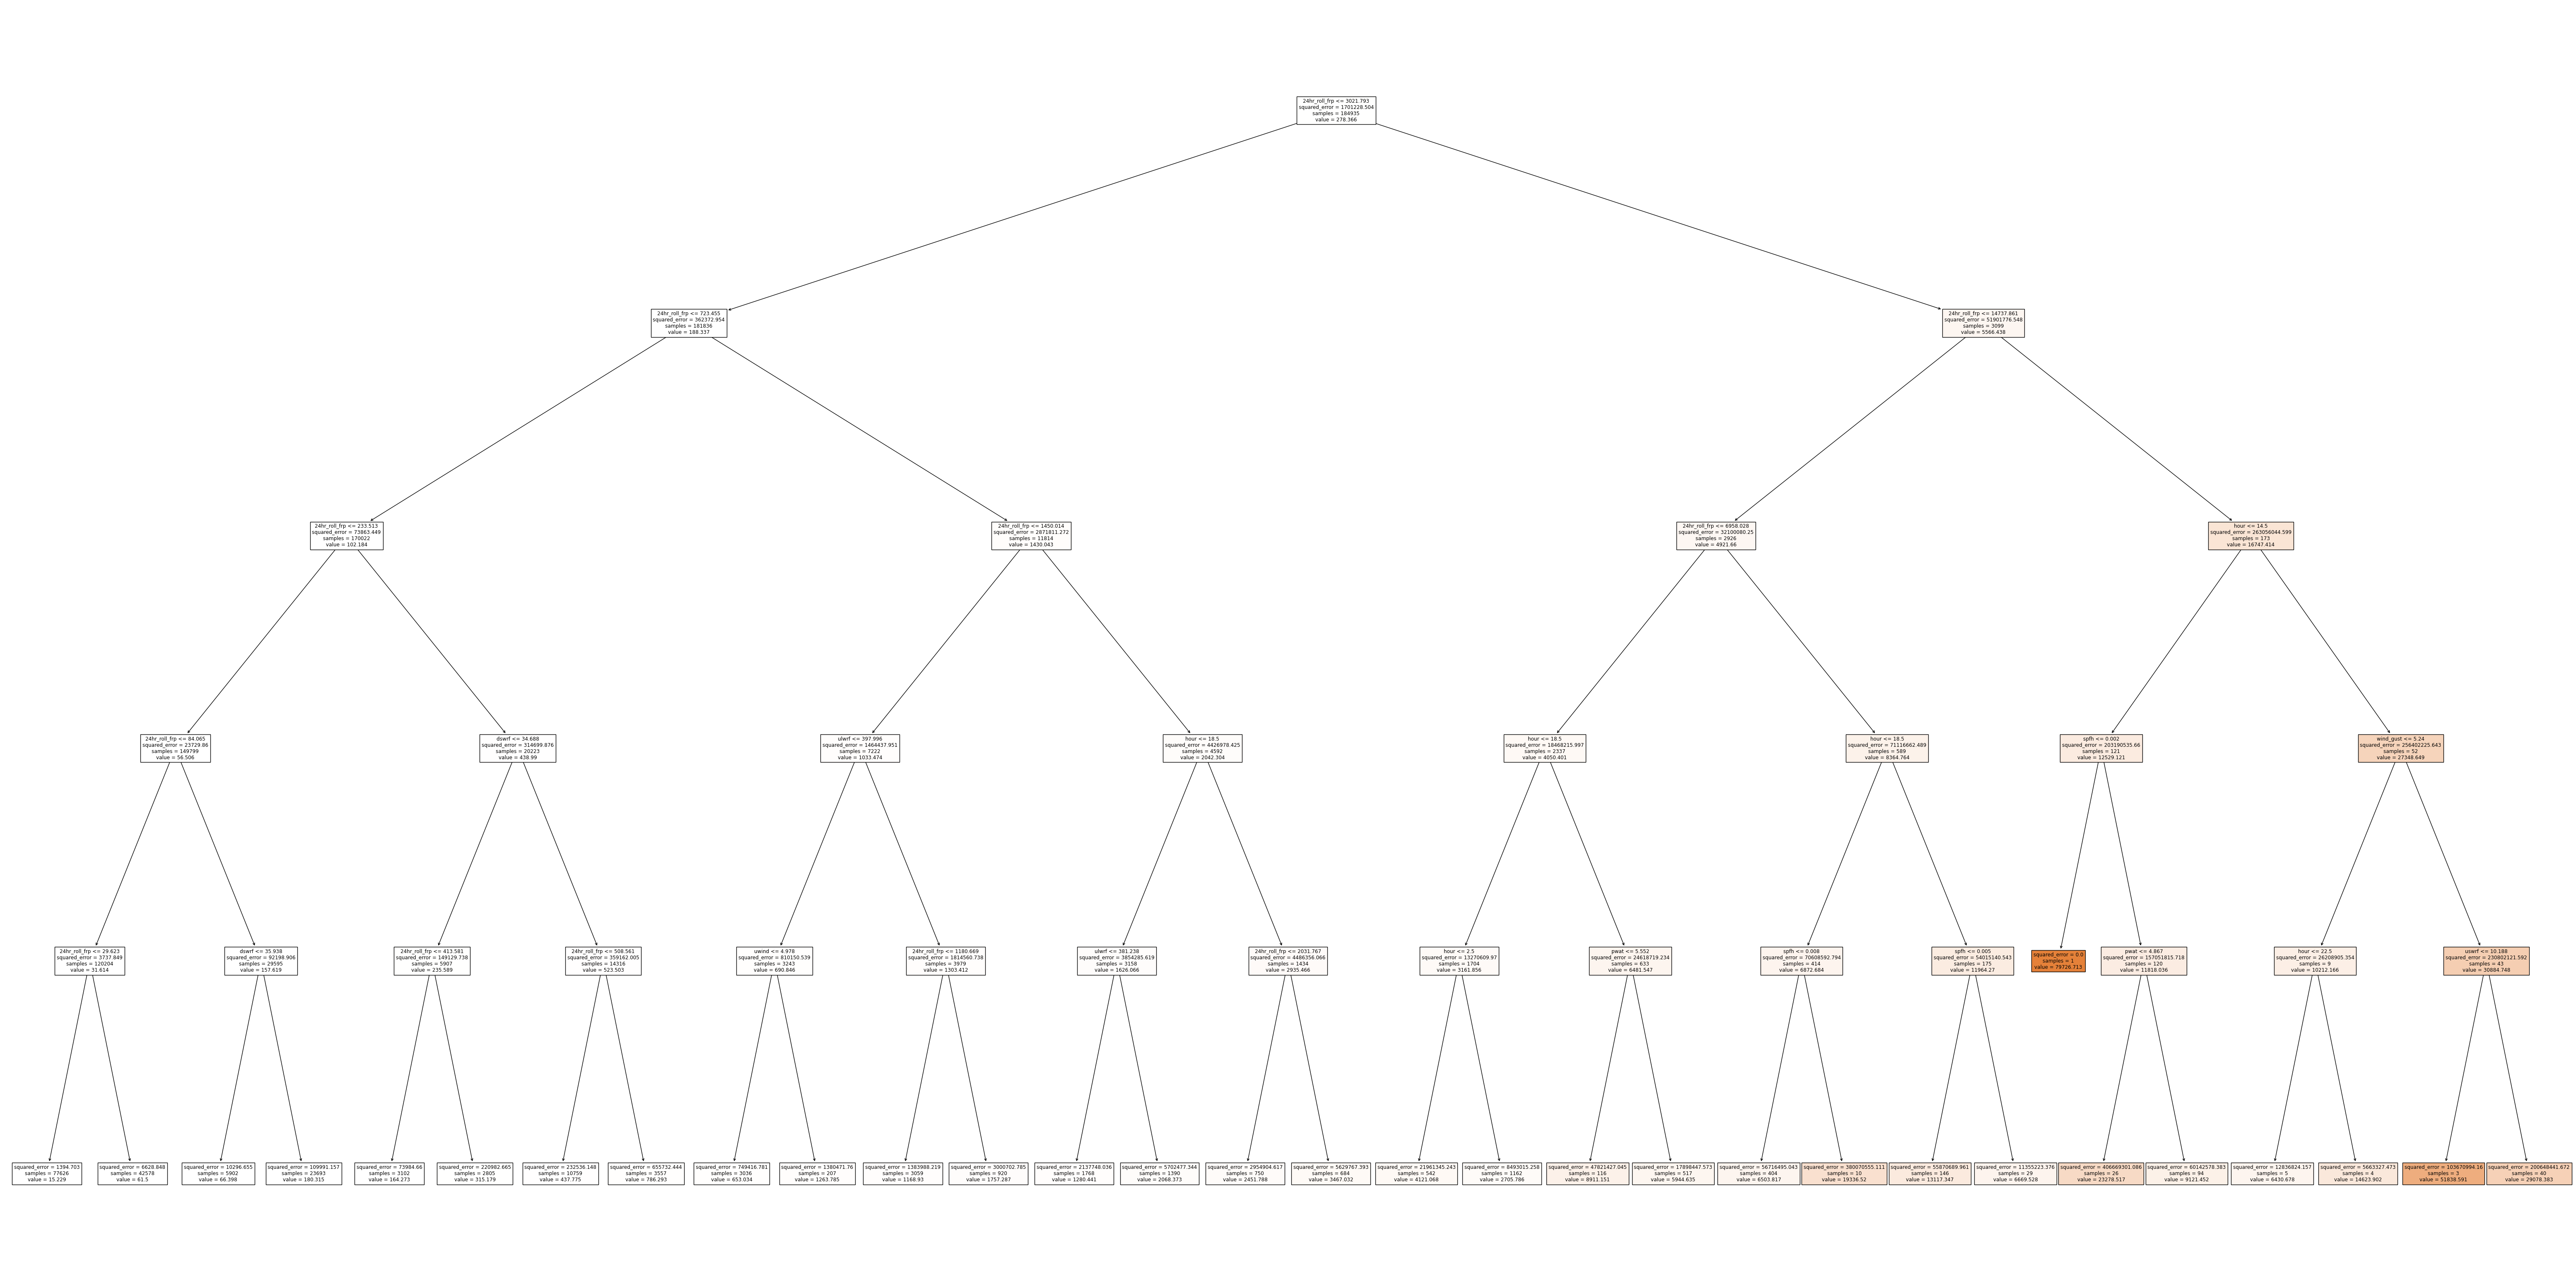

In [ ]:
from sklearn.tree import plot_tree
## specify desired tree, within initial number contraints
n_est = 10
## extract tree information
individual_tree = rf_model.estimators_[n_est]
## visualize tree
plt.figure(figsize=(80,40))
plot_tree(individual_tree, feature_names=feature_list, filled=True)
plt.show()

To see how the model did on the testing dataset, run the following code to check out the errors of the trained model.

In [ ]:
## Calculate the absolute errors
errors = abs(predictions - test_labels)
## Print out the mean absolute error (mae)
print('Mean Absolute Error for FRP:', round(np.mean(errors), 2))
print('Mean Squared Error:', metrics.mean_squared_error(test_labels, predictions))

Mean Absolute Error for FRP: 181.15
Mean Squared Error: 684279.4554388558



If you want to save the model, this is how to do it. Trained ML models are large files. In the next sub-section, we will practice opening the saved model and using it to make hourly FRP predictions on the validation data.


In [ ]:
## Save the model to disk
filename = './RF_RAVE_RAP_MODEL_TUTORIAL.sav'

print('saving model: ', filename)
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)
## write to the file
bytes_out = pickle.dumps(rf_model)
with open(filename, 'wb') as f_out:
    for idx in range(0, len(bytes_out), max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])

2.1.4 We can also check the errors of the trained model against the dataset that we held back. Since this data was completely withheld, this process is called *inference* and is an example how a pretrained model can be used on future or unseen data in application. As is the case with any pretrained models, our input variable selection must be the same input variable selection as the trained model. We cannot only add a few inputs or add extra inputs. It will cause an error.



In [ ]:
## define the input variables
validate_features = frp_validate[['lat', 'lon', 'hour', 'temp2m', 'wind_gust', 'precip', 'dpt', 'uwind', 'vwind',
                                'temp_surf', 'snod', 'spfh', 'pwat', 'weasd', 'dswrf', 'uswrf', 'dlwrf', 'ulwrf',
                                'cape', 'ltng', 'tsoil', 'soilw', 'vgtyp', 'sotyp', '24hr_roll_frp']]

## define the target or output variable
validate_labels = frp_validate['rave_frp']

## run the inference stage and save output into a new column in the validate dataframe
validate_result = rf_model.predict(validate_features)
frp_validate['RF_FRP'] = validate_result
print('finished creating the RF FRP values')

## Calculate the absolute errors
errors = abs(validate_result - validate_labels)
## Print out the mean absolute error (mae)
print('Mean Absolute Error for FRP for validation dataset:', round(np.mean(errors), 2))
print('Mean Squared Error for validation dataset:', metrics.mean_squared_error(validate_labels, validate_result))

Below is example code that shows how to open a previously saved RF model, saved with the name/location of *filename*, and run the inference stage on a set of input variables called *test_features*.

```
## open the previously saved RF model
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(test_features)
```


Congratulations! You have successfully completed the interference stage. Remember, you can return to the beginning of section 2.1.2 to apply more conditionals to the dataset. Try rerunning section 2.1 with different inputs and conditionals!

# 2.2 Analyze the performance of the RF Model

In this section, we will apply different tools to the trained RF model to analyze its performance. You will have needed to train the RF model in section 2.1 to apply these tools to the RF model.


# Next Steps

By creating an ML-ready dataset, we can apply this to all sorts of ML modeling methods. For instance, the dataset and pretrained model used in section two are used to create a complete hourly FRP variable. This variable can now be used as a consistent FRP variable for future time steps in another, potentially ML, model.

2.2.1 In this subsection, we will step through the short code to calculate the importances of the input variables, or features, in the RF model. The importances will sum to 1 and are ranked as most important in determining the hourly FRP value to least important. It is not a direct scientific correlation to hourly FRP and the variables we have used to train the mode. It is a direct measure of what the model has determined as the most important to least important features in calculating the hourly FRP. To learn more about this tool in python, please reference:

In [ ]:
## Get numerical feature importances
importances = list(rf_model.feature_importances_)

## List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

## Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

## Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

2.2.2 Here, we can visualize the performance of the model on the blind validation dataset we reserved. This plotting code will plot the truth, or the FRP retrieval for that gridcell at that hour, compared to our RF modeled FRP value for that hour.

In [ ]:
## Define the 1:1 line
lineStart = validate_labels.min()
lineEnd = validate_labels.max()

## Check out the actual test versus predictors with 1:1 line
fig1 = plt.gcf()
plt.scatter(validate_labels, validate_result, c='b', marker='x', alpha=0.15, label='RF')
line = mlines.Line2D([0, 1], [0, 1], color='red')
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.xlabel('Truth FRP (MW)'); plt.ylabel('Predicted FRP (MW)')
plt.title('RAVE Observed Versus Modeled FRP')
plt.legend(loc="upper left", title='Models')
plt.tight_layout()

Congratulations! You have finished the Machine Learning for Fire Radiative Power Modeling notebook.

# References

Blaylock, B. K. (2022). Herbie: Retrieve Numerical Weather Prediction Model Data (Version 2022.9.0) [Computer software]. https://doi.org/10.5281/zenodo.4567540

Fangjun Li, Xiaoyang Zhang, Shobha Kondragunta, Xiaoman Lu, Ivan Csiszar, Christopher C. Schmidt, Hourly biomass burning emissions product from blended geostationary and polar-orbiting satellites for air quality forecasting applications, Remote Sensing of Environment, Volume 281, 2022,113237, ISSN 0034-4257, https://doi.org/10.1016/j.rse.2022.113237.
(https://www.sciencedirect.com/science/article/pii/S0034425722003431)

# Data Statement

Data and pretrained model storage located on zenodo at DOI https://doi.org/10.5281/zenodo.10463552



## Disclaimer
This Google CoLab Jupyter is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Google CoLab Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Google CoLab Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.